In [70]:
# notebooks use their location as their working directory, so
# if we are in a subfolder, move to the main folder.  
# This however can safely be run multiple times
if(!dir.exists("Functions/")){
    setwd("../")
}
source("Functions/lecospectR.R", echo = FALSE)
library(class)
library(caret)
library(vegan)

## Load the Data

In [71]:
# spectral library
base_path <- "./Output/C_001_SC3_Cleaned_SpectralLib.csv"
veg_index_path <- "./Data/D_002_SpecLib_Derivs.csv"
speclib <- read.csv(base_path)
veg_indices <- read.csv(veg_index_path)

In [72]:
# Targets 
targets <- veg_indices[!is.na(veg_indices$Functional_group1),"Functional_group1"] %>% as.factor()
# weights
weights_by_pft <- targets_to_weights(targets)

In [73]:
# image-based validation
uav_speclib_df <- read.csv(
    "Data/Ground_Validation/PFT_image_spectra/PFT_Image_SpectralLib_Clean_unsmoothed.csv", 
    header = TRUE)
image_validation <- uav_speclib_df[,16:(ncol(uav_speclib_df) - 1)]
validation_labels <- uav_speclib_df$FncGrp1 %>% as.factor()
levels(validation_labels) <- c(
    levels(validation_labels),
    "Forb") 



## Base transformation
This removes infinity, outliers and NAs from the data.  

[1] "Imputing..."
[1] "Imputing..."
[1] 1258  161


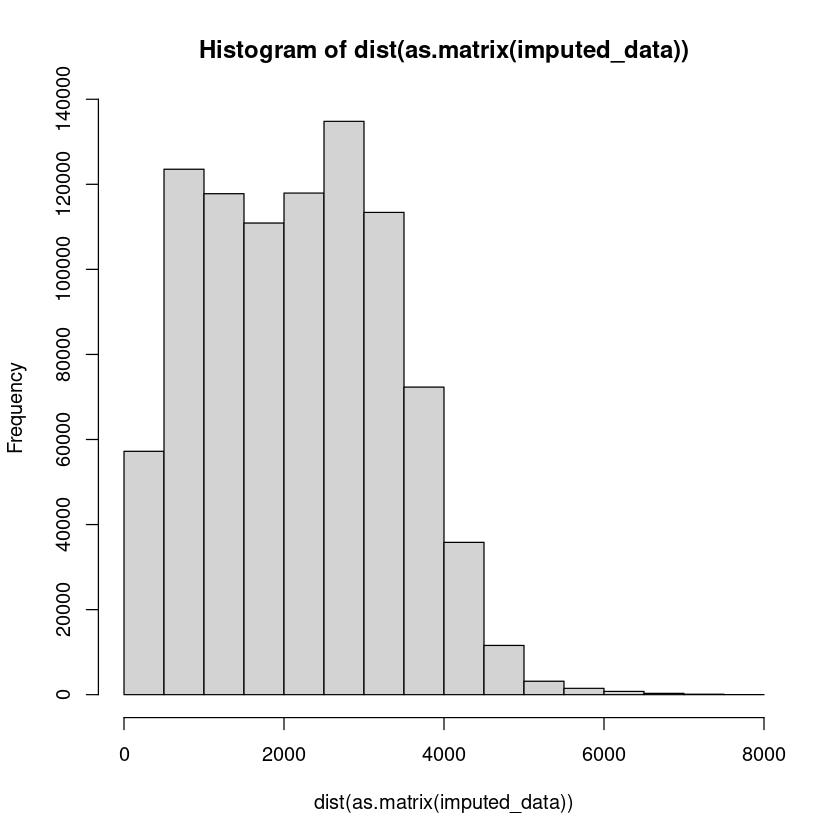

In [74]:
numeric_data <- veg_indices[!is.na(veg_indices$Functional_group1),35:195]
numeric_data <- inf_to_na(numeric_data)
imputed_data_1 <- impute_spectra(numeric_data)
imputed_data_no_outliers <- outliers_to_na(imputed_data_1)
imputed_data <- impute_spectra(imputed_data_no_outliers)
outlier_indices <- detect_outliers_columnwise(imputed_data[,1:95])
filtered_data <- imputed_data[!outlier_indices,]
hist(dist(as.matrix(imputed_data)))
min_max_scaled_data <- columnwise_min_max_scale(imputed_data)

## Transform the Image-based Data

In [75]:
veg_index_names <- read.csv("assets/vegIndicesUsed.csv")$x
validation_indices <- get_vegetation_indices(image_validation, NULL)
# drop NAs

validation_indices <- inf_to_na(validation_indices)
validation_indices <- impute_spectra(validation_indices)
validation_indices <- outliers_to_na(validation_indices)
validation_indices <- impute_spectra(validation_indices)


min_max_scaled_validation <- columnwise_min_max_scale(validation_indices)

#hist(as.matrix(min_max_scaled_validation))

[1] "Imputing..."
[1] "Imputing..."


In [76]:
print(summary(min_max_scaled_validation))

     Boochs          Boochs2            CARI            Carter      
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.3745   1st Qu.:0.3757   1st Qu.:0.3217   1st Qu.:0.3662  
 Median :0.5013   Median :0.5181   Median :0.4347   Median :0.4852  
 Mean   :0.4976   Mean   :0.4983   Mean   :0.4867   Mean   :0.5026  
 3rd Qu.:0.6250   3rd Qu.:0.6257   3rd Qu.:0.5931   3rd Qu.:0.6077  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
    Carter2          Carter3          Carter4          Carter5      
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.1930   1st Qu.:0.2054   1st Qu.:0.1946   1st Qu.:0.3347  
 Median :0.2411   Median :0.2582   Median :0.2585   Median :0.4781  
 Mean   :0.3950   Mean   :0.3976   Mean   :0.3801   Mean   :0.4815  
 3rd Qu.:0.5161   3rd Qu.:0.5242   3rd Qu.:0.5220   3rd Qu.:0.6021  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
    Carter6             CI        

In [77]:
image_weights <- targets_to_weights(validation_labels %>% as.factor())

## PCA 
This is where we calcuate PCA for the ground and image spectra

In [ ]:
# fit a PCA to the ground spectra
pca_fit <- stats::prcomp(imputed_data[,1:(ncol(numeric_data) - 66)], center = FALSE, scale. = FALSE)
print(summary(pca_fit))
pca_training_data <- predict(pca_fit, imputed_data[,1:(ncol(numeric_data) - 66)])[,1:64]
boxplot(vegan::scores(pca_training_data)[,2]~targets)

## Standardization
This cell standardizes the input to center at zero with standard deviation one.

In [78]:
# standardization
indice_standardizer <- caret::preProcess(imputed_data[,1:95])
standardized_indices <- predict(indice_standardizer, imputed_data[,1:95])

val_standardizer <- caret::preProcess(validation_indices)
standardized_validation <- predict(val_standardizer, validation_indices)

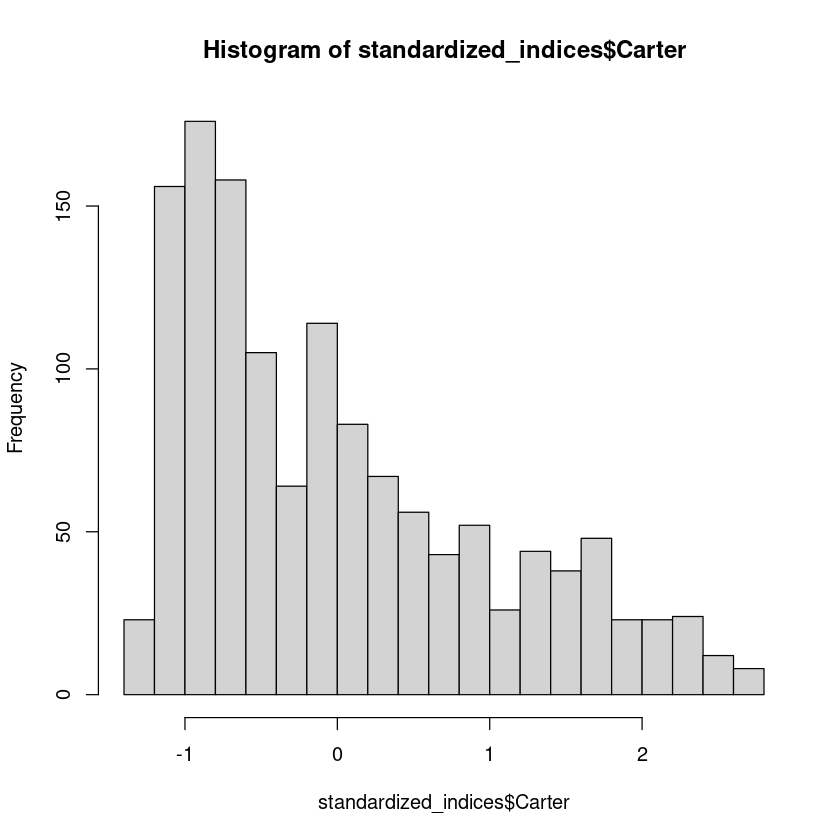

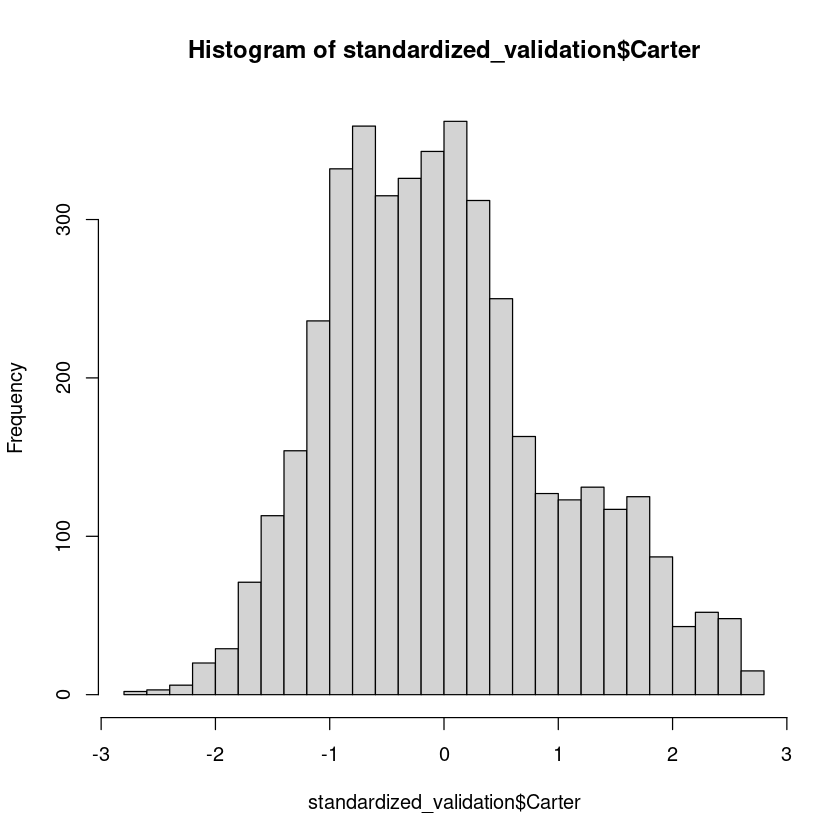

In [79]:
hist(standardized_indices$Carter, breaks = 20)
hist(standardized_validation$Carter, breaks = 20)

## Min-Max Scaling
This executes the min-man scalaing (to make the data on the scale [0,1])

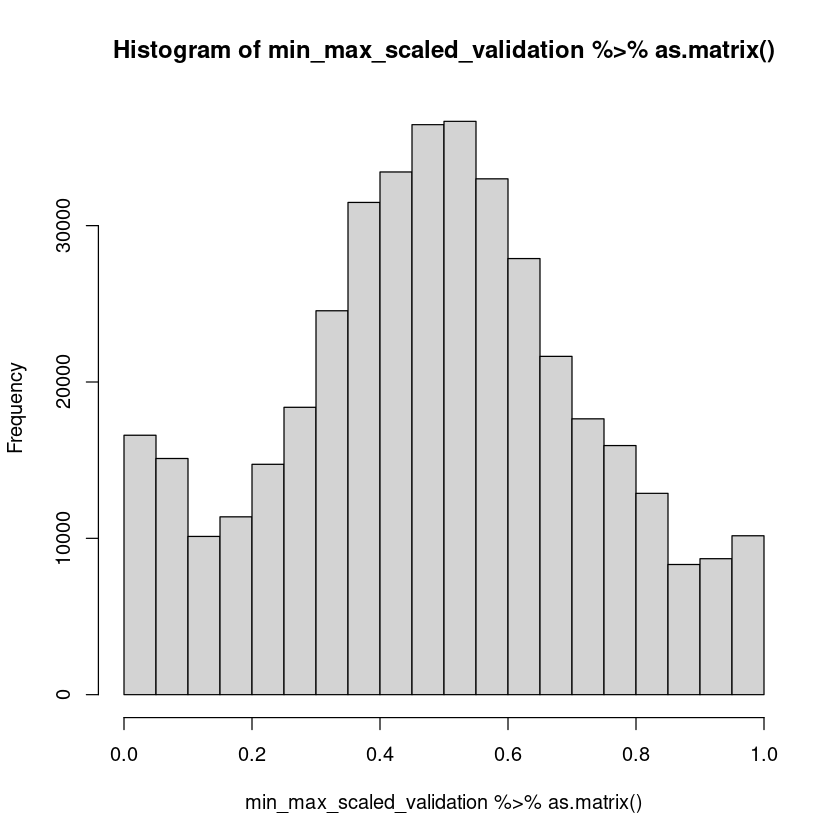

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'as.data.frame': error in evaluating the argument 'object' in selecting a method for function 'predict': object 'pca_fit' not found


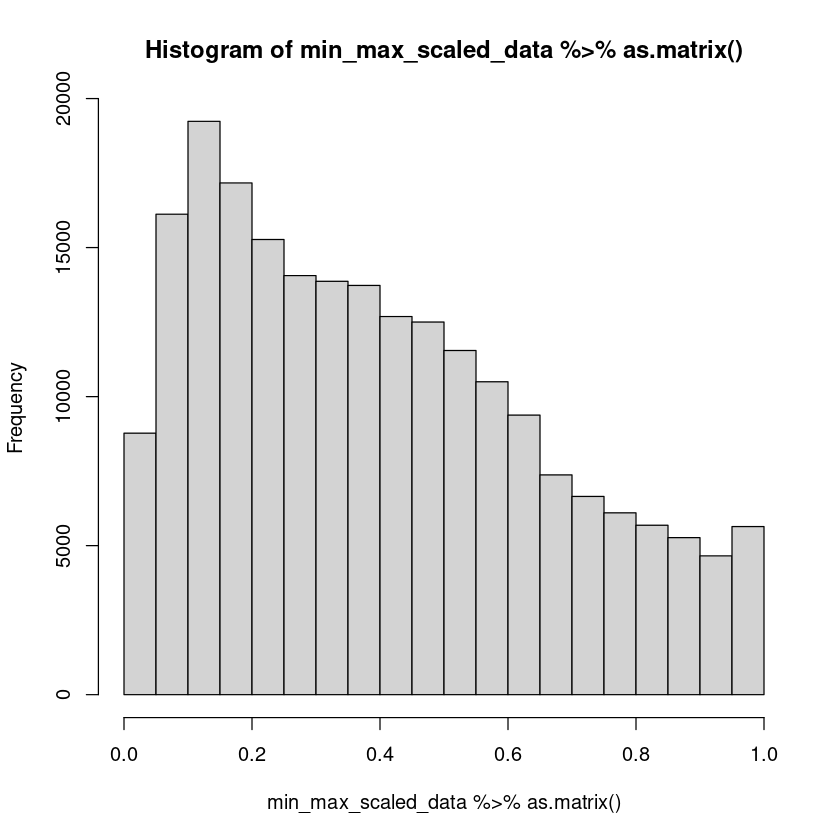

In [80]:
# plots
hist(min_max_scaled_validation %>% as.matrix())
hist(min_max_scaled_data %>% as.matrix())
pca_validation_data <- predict(pca_fit, validation_indices[!validation_outliers,])[,1:64] %>% as.data.frame()
boxplot(vegan::scores(pca_validation_data)[,2]~validation_labels[!validation_outliers])

## KS Tests of Transferrability
These next few cells test whether the veg indices are similarly distributed (i.e. could be samples drawn from the same distribution)

The hypothesis is that columns (veg indices) that pass this test can safely be used across models and conditions (are transferrable)

In [83]:
source("Functions/lecospectR.R")
ks_test_results <- test_transferrability(min_max_scaled_data, min_max_scaled_validation)
print(ks_test_results)

Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate in the presence of ties”
Warning message in ks.test.default(df1[, col], df2[, col]):
“p-value will be approximate

$Boochs

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.19591, p-value < 2.2e-16
alternative hypothesis: two-sided


$Boochs2

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.35689, p-value < 2.2e-16
alternative hypothesis: two-sided


$CARI

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.13392, p-value = 2.22e-16
alternative hypothesis: two-sided


$Carter

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.42291, p-value < 2.2e-16
alternative hypothesis: two-sided


$Carter2

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.35641, p-value < 2.2e-16
alternative hypothesis: two-sided


$Carter3

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.38668, p-value < 2.2e-16
alternative hypothesis: two-sided


$Carter4

	Asymptotic two-sample Kolmogorov-Smirnov test

## t-SNE
Examine the clusters in the data via *t*-SNE

 [1] "N"                   "Y"                   "costs"              
 [4] "itercosts"           "origD"               "perplexity"         
 [7] "theta"               "max_iter"            "stop_lying_iter"    
[10] "mom_switch_iter"     "momentum"            "final_momentum"     
[13] "eta"                 "exaggeration_factor"


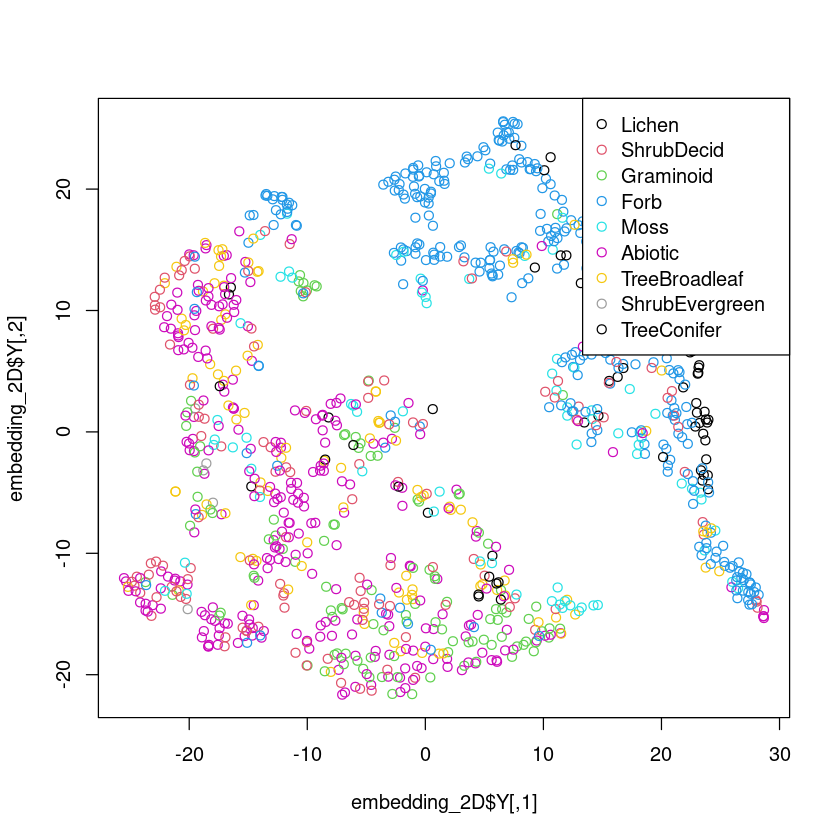

In [ ]:
library(Rtsne)
unique_indices <- imputed_data[!duplicated(imputed_data),1:95]
normalized_veg_indices <- Rtsne::normalize_input(
    unique_indices %>% 
    as.matrix()
    )
embedding_2D <- Rtsne::Rtsne(normalized_veg_indices)
print(names(embedding_2D))

plot(embedding_2D$Y, col = as.factor(targets))
par(xpd=T)
legend("topright", legend = unique(targets), col = seq_along(unique(targets)),pch = 1)

## Vector Quantization Classifier
This fits a LVQ classifier to the data and then 

In [ ]:
print(length(validation_labels))
print(nrow(min_max_scaled_validation))

[1] 4264
[1] 4264


In [84]:
# method 1 - transfers with 23% accuracy, which is one of the best actually
library(class)
codeBook <-  lvqinit(
    min_max_scaled_data[,1:95], 
    targets, 
10)
code_book_train <- class::olvq1(min_max_scaled_data[,1:95], targets, codeBook)
prediction <- class::lvqtest(code_book_train, min_max_scaled_data[,1:95])
lvq_conf <- caret::confusionMatrix(prediction, targets, mode = "everything")

#print(lvq_conf)

image_prediction <- class::lvqtest(code_book_train, min_max_scaled_validation)

lvq_validation_conf <- caret::confusionMatrix(image_prediction, validation_labels, mode = "everything")



Warning message in confusionMatrix.default(image_prediction, validation_labels, :
“Levels are not in the same order for reference and data. Refactoring data to match.”


In [ ]:
print(lvq_conf)

Confusion Matrix and Statistics

                Reference
Prediction       Abiotic Forb Graminoid Lichen Moss ShrubDecid ShrubEvergreen
  Abiotic             84    0         0     33    0          0              0
  Forb                 0    0         0      0    0          0              0
  Graminoid            0    0         0      0    0          0              0
  Lichen               5   47        22    370   45         26             25
  Moss                 4    0         4      9   72          1              2
  ShrubDecid           1  111        86      5    5        270             77
  ShrubEvergreen       0    0         0      0    0          0              1
  TreeBroadleaf        0    0         0      0    0          0              0
  TreeConifer          0    0         0      0    0          0              0
                Reference
Prediction       TreeBroadleaf TreeConifer
  Abiotic                    0           0
  Forb                       0           0
  Gram

In [ ]:
print(lvq_validation_conf)

Confusion Matrix and Statistics

                Reference
Prediction       Abiotic Graminoid Lichen Moss ShrubDecid ShrubEvergreen
  Abiotic            514         0      0    0          0              4
  Graminoid            0         0      0    0          0              0
  Lichen             305        39    155   24         54            195
  Moss                 0         8      0    7         11              9
  ShrubDecid           1        98      0    0         64             14
  ShrubEvergreen       0         0      0    0          0              0
  TreeBroadleaf        0         0      0    0          0              0
  TreeConifer          0         0      0    0          0              0
  Forb                 0         0      0    0          0              0
                Reference
Prediction       TreeBroadleaf TreeConifer Forb
  Abiotic                    0           0    0
  Graminoid                  0           0    0
  Lichen                     0         22

## Train-Test Split

Perform an 80-20 split on the data (use the split on the fly during the grid search)

In [89]:
grd_train_idx <- caTools::sample.split(targets, SplitRatio = 0.8)

In [90]:
img_train_idx <- caTools::sample.split(validation_labels, SplitRatio = 0.8)

## Random Forest
trains a random forest model

In [85]:

rf_model <- ranger::ranger(
    num.trees = 256,
    case.weights = image_weights,
    classification = TRUE,
    x = validation_indices,
    y = validation_labels
)

print(rf_model)

Warning message:
“Dropped unused factor level(s) in dependent variable: Forb.”


Ranger result

Call:
 ranger::ranger(num.trees = 256, case.weights = image_weights,      classification = TRUE, x = validation_indices, y = validation_labels) 

Type:                             Classification 
Number of trees:                  256 
Sample size:                      4264 
Number of independent variables:  95 
Mtry:                             9 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             3.88 % 


In [86]:
predictions <- predict(rf_model, validation_indices)$predictions %>% 
    as.factor()
confusion_matrix <- caret::confusionMatrix(
    predictions, 
    validation_labels, 
    mode = "everything")
print(confusion_matrix)

Confusion Matrix and Statistics

                Reference
Prediction       Abiotic Graminoid Lichen Moss ShrubDecid ShrubEvergreen
  Abiotic            820         0      0    0          0              0
  Graminoid            0       145      0    0          0              0
  Lichen               0         0    155    0          0              0
  Moss                 0         0      0   31          0              0
  ShrubDecid           0         0      0    0        129              0
  ShrubEvergreen       0         0      0    0          0            222
  TreeBroadleaf        0         0      0    0          0              0
  TreeConifer          0         0      0    0          0              0
  Forb                 0         0      0    0          0              0
                Reference
Prediction       TreeBroadleaf TreeConifer Forb
  Abiotic                    0           0    0
  Graminoid                  0          10    0
  Lichen                     0           

# Grid Search

This next section defines all the essentials for the grid search across our different candidate models. 

## Candidates

### Models
* Random Forest
* Learned Vector Quantization (LVQ)
* k-Nearest Neighbor (kNN)

Could also consider Support Vector Machine (SVM), Gradient Boosted Trees (e.g. LightGBM, XGBoost), matched filtering, Logistic Regression, etc.

### Data/Transformations

For each of the image/training data sets, test the following:
* raw, 
* raw (no outliers)
* standardized (z-score standardization)
* standardized (z-score standardization, no outliers)
* min-max scaled
* min-max scaled (no outliers)
* PCA
* PCA no outliers

Need to also vary how many columns are included in the analysis

In [130]:
# define the data sets to loop over
gs_train <- list(
    min_max_scaled_data[,1:95],
    min_max_scaled_validation[img_train_idx,],
    standardized_indices,
    standardized_validation[img_train_idx,]
    pca_training_data,
    pca_validation_data[img_train_idx,]
)

gs_test <- list(
    min_max_scaled_validation[-img_train_idx,],
    min_max_scaled_validation[-img_train_idx,],
    standardized_validation[-img_train_idx,],
    standardized_validation[-img_train_idx,],
    pca_validation_data[-img_train_idx],
    pca_validation_data[-img_train_idx]

)

gs_train_labels <- list(
    targets,
    validation_labels[img_train_idx],
    targets,
    validation_labels[img_train_idx],
    targets,
    validation_labels[img_train_idx],
)

gs_test_labels <- list(
    validation_labels[-img_train_idx],
    validation_labels[-img_train_idx],
    validation_labels[-img_train_idx],
    validation_labels[-img_train_idx],
    validation_labels[-img_train_idx],
    validation_labels[-img_train_idx]
)

In [117]:
gs_methods <- list(
    "svmLinear",
    #"rmda",
    "rf",
    "svmRadialWeights",
    "gbm",
    "hda"# heteroscedastic discriminant analysis
)
# add: PLS-LDA, kNN, SVM+poly Kernel, SVM+Exp Kernel, more boosting, 

In [122]:
gs_weight_text <- c(
    "prior weights",
    NULL
)

gs_weights <- list(
    weights_by_pft,
    image_weights,
    weights_by_pft,
    image_weights,
    weights_by_pft,
    image_weights
)

fit_ctrl <- caret::trainControl(
    method = "repeatedcv",
    number = 10,
    repeats = 3,
    classProbs = TRUE,
    allowParallel = TRUE
)

In [132]:
for(i in seq_along(gs_train)){
    for(j in seq_along(gs_methods)){
        # train and print intermediate results to console
        df <- data.frame(gs_train[[i]])
        df$targets <-  as.factor(gs_train_labels[[i]]) 
        print("Beginning Training")
        model <- train(
           targets ~ ., 
            data = df,
            method = gs_methods[[j]],
            trControl = fit_ctrl,
            weights = gs_weights[[i]]
            verbose = TRUE
        )
        print(model)

        model_predictions <- predict(
            model, 
            gs_test[[i]]
        ) %>% as.factor()
        
        test_labels <- gs_test_labels[[i]] %>% as.factor()
        levels(test_labels) <- c(levels(test_labels), "Forb")

        confusion_matrix <- caret::confusionMatrix(
            model_predictions, 
            test_labels,
            mode = "everything"
        )

        # append performance data to the logs for later comparison
        sink(file = "mle/logs.txt", append = TRUE)
        print("-------------------------------------------------------")
        print("---------------------- Model Data ---------------------")
        
        print(paste0("Model Type: ", gs_methods[[j]]))
        print(paste0("Data Index: ",i))
        print("---------------------- Confusion Matrix ---------------------")
        print(confusion_matrix)
        print("\n")
        print("---------------------- Class Distribution ---------------------")
        print(model_predictions %>% as.factor() %>% table())
        print("-------------------------------------------------------")
        print("\n\n")
        sink(NULL)

        
        save(model, file = paste0("mle/models/gs/model_", i, "type_", j, ".rda"))

    }
}

[1] "Beginning Training"
Support Vector Machines with Linear Kernel 

1343 samples
  95 predictor
   9 classes: 'Abiotic', 'Forb', 'Graminoid', 'Lichen', 'Moss', 'ShrubDecid', 'ShrubEvergreen', 'TreeBroadleaf', 'TreeConifer' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1210, 1207, 1209, 1207, 1210, 1209, ... 
Resampling results:

  Accuracy   Kappa    
  0.3400703  0.2571963

Tuning parameter 'C' was held constant at a value of 1
[1] "Abiotic"        "Graminoid"      "Lichen"         "Moss"          
[5] "ShrubDecid"     "ShrubEvergreen" "TreeBroadleaf"  "TreeConifer"   
[9] "Forb"          
[1] "Abiotic"        "Forb"           "Graminoid"      "Lichen"        
[5] "Moss"           "ShrubDecid"     "ShrubEvergreen" "TreeBroadleaf" 
[9] "TreeConifer"   


Warning message in confusionMatrix.default(model_predictions, test_labels, mode = "everything"):
“Levels are not in the same order for reference and data. Refactoring data to match.”


[1] "Beginning Training"
Random Forest 

1343 samples
  95 predictor
   9 classes: 'Abiotic', 'Forb', 'Graminoid', 'Lichen', 'Moss', 'ShrubDecid', 'ShrubEvergreen', 'TreeBroadleaf', 'TreeConifer' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1209, 1208, 1209, 1211, 1207, 1209, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.8566492  0.8218973
  48    0.8739696  0.8435739
  95    0.8714630  0.8404269

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 48.
[1] "Abiotic"        "Graminoid"      "Lichen"         "Moss"          
[5] "ShrubDecid"     "ShrubEvergreen" "TreeBroadleaf"  "TreeConifer"   
[9] "Forb"          
[1] "Abiotic"        "Forb"           "Graminoid"      "Lichen"        
[5] "Moss"           "ShrubDecid"     "ShrubEvergreen" "TreeBroadleaf" 
[9] "TreeConifer"   


Warning message in confusionMatrix.default(model_predictions, test_labels, mode = "everything"):
“Levels are not in the same order for reference and data. Refactoring data to match.”


[1] "Beginning Training"


Warning message:
“model fit failed for Fold01.Rep1: sigma=0.01417, C=0.25, Weight=2 Error in names(wts) <- levels(y) : 
  'names' attribute [9] must be the same length as the vector [2]
”
Warning message:
“model fit failed for Fold01.Rep1: sigma=0.01417, C=0.50, Weight=2 Error in names(wts) <- levels(y) : 
  'names' attribute [9] must be the same length as the vector [2]
”
Warning message:
“model fit failed for Fold01.Rep1: sigma=0.01417, C=1.00, Weight=2 Error in names(wts) <- levels(y) : 
  'names' attribute [9] must be the same length as the vector [2]
”
Warning message:
“model fit failed for Fold01.Rep1: sigma=0.01417, C=0.25, Weight=3 Error in names(wts) <- levels(y) : 
  'names' attribute [9] must be the same length as the vector [2]
”
Warning message:
“model fit failed for Fold01.Rep1: sigma=0.01417, C=0.50, Weight=3 Error in names(wts) <- levels(y) : 
  'names' attribute [9] must be the same length as the vector [2]
”
Warning message:
“model fit failed for Fold01.Rep1: sigma=0.

Support Vector Machines with Class Weights 

1343 samples
  95 predictor
   9 classes: 'Abiotic', 'Forb', 'Graminoid', 'Lichen', 'Moss', 'ShrubDecid', 'ShrubEvergreen', 'TreeBroadleaf', 'TreeConifer' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1208, 1207, 1209, 1209, 1209, 1212, ... 
Resampling results across tuning parameters:

  C     Weight  Accuracy   Kappa    
  0.25  1       0.6962638  0.6095324
  0.25  2             NaN        NaN
  0.25  3             NaN        NaN
  0.50  1       0.7369228  0.6659881
  0.50  2             NaN        NaN
  0.50  3             NaN        NaN
  1.00  1       0.7823029  0.7257189
  1.00  2             NaN        NaN
  1.00  3             NaN        NaN

Tuning parameter 'sigma' was held constant at a value of 0.01416549
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.01416549, C = 1 and Weight
 = 1.
[1] "Abiotic"    

Warning message in confusionMatrix.default(model_predictions, test_labels, mode = "everything"):
“Levels are not in the same order for reference and data. Refactoring data to match.”


[1] "Beginning Training"
Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        2.1972            -nan     0.1000    0.5888
     2        1.8760            -nan     0.1000    0.3111
     3        1.6902            -nan     0.1000    0.2057
     4        1.5652            -nan     0.1000    0.1615
     5        1.4647            -nan     0.1000    0.1497
     6        1.3757            -nan     0.1000    0.1087
     7        1.3059            -nan     0.1000    0.0738
     8        1.2523            -nan     0.1000    0.0648
     9        1.2071            -nan     0.1000    0.0782
    10        1.1587            -nan     0.1000    0.0565
    20        0.9040            -nan     0.1000    0.0197
    40        0.6975            -nan     0.1000   -0.0044
    60        0.5978            -nan     0.1000   -0.0028
    80        0.5268            -nan     0.1000   -0.0077
   100        0.4708            -nan     0.1000   -0.0046
   120        0.4287            -nan     0.1000

Warning message in confusionMatrix.default(model_predictions, test_labels, mode = "everything"):
“Levels are not in the same order for reference and data. Refactoring data to match.”


[1] "Beginning Training"
Initialization by the identity.
Iteration 1 Log Likelihood:  45294.5883801783 
Iteration 2 Log Likelihood:  47581.9041292052 
Iteration 3 Log Likelihood:  47581.9041292052 
Iteration 4 Log Likelihood:  47581.9041292052 
Iteration 5 Log Likelihood:  47581.9041292052 
Iteration 6 Log Likelihood:  47581.9041292052 
Iteration 7 Log Likelihood:  47581.9041292052 
Initialization by the identity.
Iteration 1 Log Likelihood:  46269.6078500322 
Iteration 2 Log Likelihood:  74941.0898779239 
Iteration 3 Log Likelihood:  74941.0898779239 
Iteration 4 Log Likelihood:  74941.0898779239 
Iteration 5 Log Likelihood:  74941.0898779239 
Iteration 6 Log Likelihood:  74941.0898779239 
Iteration 7 Log Likelihood:  74941.089877924 
Initialization by the identity.
Iteration 1 Log Likelihood:  48650.4228250936 
Iteration 2 Log Likelihood:  264722.495645971 
Iteration 3 Log Likelihood:  264722.495645951 
Iteration 4 Log Likelihood:  264722.495645948 
Iteration 5 Log Likelihood:  26472

Warning message:
“model fit failed for Fold03.Rep1: gamma=1.00, lambda=1.0, newdim=2 Error in solve.default(G) : 
  system is computationally singular: reciprocal condition number = 7.16539e-19
”


Initialization by the identity.
Iteration 1 Log Likelihood:  45108.8508646514 
Iteration 2 Log Likelihood:  47398.098228104 
Iteration 3 Log Likelihood:  47398.098228104 
Iteration 4 Log Likelihood:  47398.0982281041 
Iteration 5 Log Likelihood:  47398.0982281041 
Iteration 6 Log Likelihood:  47398.098228104 
Iteration 7 Log Likelihood:  47398.0982281041 
Initialization by the identity.
Iteration 1 Log Likelihood:  46083.7391024939 
Iteration 2 Log Likelihood:  74751.0007827411 
Iteration 3 Log Likelihood:  74751.0007827411 
Iteration 4 Log Likelihood:  74751.0007827411 
Iteration 5 Log Likelihood:  74751.0007827411 
Iteration 6 Log Likelihood:  74751.0007827411 
Iteration 7 Log Likelihood:  74751.0007827411 
Initialization by the identity.
Iteration 1 Log Likelihood:  48473.8404799929 
Iteration 2 Log Likelihood:  269100.254410209 
Iteration 3 Log Likelihood:  269100.254410241 
Iteration 4 Log Likelihood:  269100.254410624 
Iteration 5 Log Likelihood:  269100.254410282 
Iteration 6 Lo

Warning message:
“model fit failed for Fold03.Rep1: gamma=1.00, lambda=1.0, newdim=3 Error in solve.default(G) : 
  system is computationally singular: reciprocal condition number = 7.45131e-19
”


# Results

These are the results of the grid search on the basics.  High performing models get to go through validation

## Top performers:
* 